## Documentação
O foco será na aplicação de modelos combinamos afim de obter consitência nas previsões ao invés de uma posição atraente no `lb`.


Recursos:
- np.logspace - https://numpy.org/doc/stable/reference/generated/numpy.logspace.html
- xgb doc - https://xgboost.readthedocs.io/en/stable/tutorials/model.html

In [1]:
approach = { 
    
    "cross-val": "5 folders",
    "encoder": "OneHot"
}

## Código

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = 10, 7
plt.rcParams['font.size'] = 12

from sklearn.model_selection import train_test_split

import xgboost as xgb
import optuna


from sklearn.feature_selection import SelectKBest, chi2
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.metrics import roc_auc_score, make_scorer
from sklearn.metrics import mean_squared_log_error

URL_TRAIN = '/kaggle/input/surrogate-playground-series-s4e4/train.csv'
URL_SAMPLE = '/kaggle/input/surrogate-playground-series-s4e4/sample_submission.csv'
URL_TEST = '/kaggle/input/surrogate-playground-series-s4e4/test.csv'

N_SAMPLE = 4000
TARGET = 'Rings'
SEED = 101

In [3]:
%%time

# Carregar dados
train = pd.read_csv(URL_TRAIN, index_col='id') 

# Separar dados de treino e teste
X, y = train.drop(TARGET, axis=1), train[TARGET]
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3)

# Parâmetros para o XGBOOST
params =  {
    
    "classifier__booster":['dart', 'gbtree', 'gblinear'], # Booster
    "classifier__eta": np.logspace(0, -5, num=10), # Learning rate
    "classifier__gamma": np.arange(1, 5, 1)
}

# Modelo
base_regressor = xgb.XGBRegressor(tree_method='hist', device='cuda') # <- Configuração para usar GPU

# Definir transformações nos dados
numeric_features = X.select_dtypes(exclude=['object']).columns
numeric_transformer = Pipeline( # <- Aplicar Scaling aos dados
        steps=[("scaler", StandardScaler())]) 

categorical_features = X.select_dtypes(include=['object']).columns
categorical_transformer = Pipeline(# <- Codificar as variáveis categóricas
        steps=[("encoder", OneHotEncoder())]) 

preprocessor = ColumnTransformer( # <- Combinar as transformações
        transformers=[
            ("num", numeric_transformer, numeric_features),
            ('cat', categorical_transformer, categorical_features)])

clf = Pipeline( # <- Combinar transformações e modelo escolhido
        steps=[
            ("preprocessor", preprocessor),
            ("classifier", base_regressor)])

# Método de validação cruzada
kfold = KFold(n_splits=5) # <- Cinco pastas

# Busca pelos melhores parâmetros
grid = GridSearchCV( 
        clf,
        param_grid=params, verbose=4)

model = grid.fit(X_train, y_train)

Fitting 5 folds for each of 120 candidates, totalling 600 fits


/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [22:27:42] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END classifier__booster=dart, classifier__eta=1.0, classifier__gamma=1;, score=0.178 total time=   2.0s
[CV 2/5] END classifier__booster=dart, classifier__eta=1.0, classifier__gamma=1;, score=0.166 total time=   1.6s
[CV 3/5] END classifier__booster=dart, classifier__eta=1.0, classifier__gamma=1;, score=0.168 total time=   1.6s
[CV 4/5] END classifier__booster=dart, classifier__eta=1.0, classifier__gamma=1;, score=0.181 total time=   1.6s
[CV 5/5] END classifier__booster=dart, classifier__eta=1.0, classifier__gamma=1;, score=0.174 total time=   1.6s
[CV 1/5] END classifier__booster=dart, classifier__eta=1.0, classifier__gamma=2;, score=0.173 total time=   1.6s
[CV 2/5] END classifier__booster=dart, classifier__eta=1.0, classifier__gamma=2;, score=0.186 total time=   1.5s
[CV 3/5] END classifier__booster=dart, classifier__eta=1.0, classifier__gamma=2;, score=0.170 total time=   1.6s
[CV 4/5] END classifier__booster=dart, classifier__eta=1.0, classifier__gamma=2;, score=0.229 to

/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [22:33:56] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "gamma", "tree_method" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END classifier__booster=gblinear, classifier__eta=1.0, classifier__gamma=1;, score=0.352 total time=   0.4s


/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [22:33:57] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "gamma", "tree_method" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END classifier__booster=gblinear, classifier__eta=1.0, classifier__gamma=1;, score=0.328 total time=   0.3s


/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [22:33:57] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "gamma", "tree_method" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END classifier__booster=gblinear, classifier__eta=1.0, classifier__gamma=1;, score=0.336 total time=   0.4s


/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [22:33:57] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "gamma", "tree_method" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END classifier__booster=gblinear, classifier__eta=1.0, classifier__gamma=1;, score=0.326 total time=   0.4s


/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [22:33:58] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "gamma", "tree_method" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END classifier__booster=gblinear, classifier__eta=1.0, classifier__gamma=1;, score=0.340 total time=   0.4s


/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [22:33:58] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "gamma", "tree_method" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END classifier__booster=gblinear, classifier__eta=1.0, classifier__gamma=2;, score=0.347 total time=   0.3s


/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [22:33:59] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "gamma", "tree_method" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END classifier__booster=gblinear, classifier__eta=1.0, classifier__gamma=2;, score=0.334 total time=   0.4s


/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [22:33:59] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "gamma", "tree_method" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END classifier__booster=gblinear, classifier__eta=1.0, classifier__gamma=2;, score=0.331 total time=   0.3s


/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [22:33:59] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "gamma", "tree_method" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END classifier__booster=gblinear, classifier__eta=1.0, classifier__gamma=2;, score=0.328 total time=   0.4s


/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [22:34:00] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "gamma", "tree_method" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END classifier__booster=gblinear, classifier__eta=1.0, classifier__gamma=2;, score=0.337 total time=   0.4s


/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [22:34:00] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "gamma", "tree_method" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END classifier__booster=gblinear, classifier__eta=1.0, classifier__gamma=3;, score=0.344 total time=   0.4s


/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [22:34:00] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "gamma", "tree_method" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END classifier__booster=gblinear, classifier__eta=1.0, classifier__gamma=3;, score=0.332 total time=   0.4s


/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [22:34:01] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "gamma", "tree_method" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END classifier__booster=gblinear, classifier__eta=1.0, classifier__gamma=3;, score=0.328 total time=   0.4s


/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [22:34:01] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "gamma", "tree_method" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END classifier__booster=gblinear, classifier__eta=1.0, classifier__gamma=3;, score=0.329 total time=   0.4s


/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [22:34:02] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "gamma", "tree_method" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END classifier__booster=gblinear, classifier__eta=1.0, classifier__gamma=3;, score=0.331 total time=   0.3s


/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [22:34:02] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "gamma", "tree_method" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END classifier__booster=gblinear, classifier__eta=1.0, classifier__gamma=4;, score=0.345 total time=   0.4s


/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [22:34:02] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "gamma", "tree_method" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END classifier__booster=gblinear, classifier__eta=1.0, classifier__gamma=4;, score=0.328 total time=   0.3s


/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [22:34:03] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "gamma", "tree_method" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END classifier__booster=gblinear, classifier__eta=1.0, classifier__gamma=4;, score=0.328 total time=   0.3s


/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [22:34:03] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "gamma", "tree_method" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END classifier__booster=gblinear, classifier__eta=1.0, classifier__gamma=4;, score=0.333 total time=   0.4s


/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [22:34:03] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "gamma", "tree_method" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END classifier__booster=gblinear, classifier__eta=1.0, classifier__gamma=4;, score=0.331 total time=   0.4s


/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [22:34:04] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "gamma", "tree_method" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END classifier__booster=gblinear, classifier__eta=0.2782559402207124, classifier__gamma=1;, score=0.356 total time=   0.4s


/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [22:34:04] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "gamma", "tree_method" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END classifier__booster=gblinear, classifier__eta=0.2782559402207124, classifier__gamma=1;, score=0.344 total time=   0.3s


/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [22:34:04] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "gamma", "tree_method" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END classifier__booster=gblinear, classifier__eta=0.2782559402207124, classifier__gamma=1;, score=0.341 total time=   0.3s


/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [22:34:05] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "gamma", "tree_method" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END classifier__booster=gblinear, classifier__eta=0.2782559402207124, classifier__gamma=1;, score=0.341 total time=   0.4s


/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [22:34:05] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "gamma", "tree_method" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END classifier__booster=gblinear, classifier__eta=0.2782559402207124, classifier__gamma=1;, score=0.352 total time=   0.3s


/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [22:34:06] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "gamma", "tree_method" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END classifier__booster=gblinear, classifier__eta=0.2782559402207124, classifier__gamma=2;, score=0.356 total time=   0.4s


/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [22:34:06] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "gamma", "tree_method" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END classifier__booster=gblinear, classifier__eta=0.2782559402207124, classifier__gamma=2;, score=0.344 total time=   0.4s


/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [22:34:06] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "gamma", "tree_method" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END classifier__booster=gblinear, classifier__eta=0.2782559402207124, classifier__gamma=2;, score=0.341 total time=   0.4s


/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [22:34:07] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "gamma", "tree_method" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END classifier__booster=gblinear, classifier__eta=0.2782559402207124, classifier__gamma=2;, score=0.341 total time=   0.4s


/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [22:34:07] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "gamma", "tree_method" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END classifier__booster=gblinear, classifier__eta=0.2782559402207124, classifier__gamma=2;, score=0.352 total time=   0.4s


/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [22:34:07] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "gamma", "tree_method" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END classifier__booster=gblinear, classifier__eta=0.2782559402207124, classifier__gamma=3;, score=0.356 total time=   0.4s


/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [22:34:08] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "gamma", "tree_method" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END classifier__booster=gblinear, classifier__eta=0.2782559402207124, classifier__gamma=3;, score=0.344 total time=   0.4s


/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [22:34:08] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "gamma", "tree_method" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END classifier__booster=gblinear, classifier__eta=0.2782559402207124, classifier__gamma=3;, score=0.341 total time=   0.4s


/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [22:34:09] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "gamma", "tree_method" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END classifier__booster=gblinear, classifier__eta=0.2782559402207124, classifier__gamma=3;, score=0.341 total time=   0.4s


/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [22:34:09] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "gamma", "tree_method" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END classifier__booster=gblinear, classifier__eta=0.2782559402207124, classifier__gamma=3;, score=0.352 total time=   0.4s


/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [22:34:09] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "gamma", "tree_method" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END classifier__booster=gblinear, classifier__eta=0.2782559402207124, classifier__gamma=4;, score=0.356 total time=   0.3s


/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [22:34:10] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "gamma", "tree_method" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END classifier__booster=gblinear, classifier__eta=0.2782559402207124, classifier__gamma=4;, score=0.344 total time=   0.4s


/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [22:34:10] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "gamma", "tree_method" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END classifier__booster=gblinear, classifier__eta=0.2782559402207124, classifier__gamma=4;, score=0.341 total time=   0.4s


/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [22:34:11] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "gamma", "tree_method" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END classifier__booster=gblinear, classifier__eta=0.2782559402207124, classifier__gamma=4;, score=0.341 total time=   0.4s


/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [22:34:11] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "gamma", "tree_method" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END classifier__booster=gblinear, classifier__eta=0.2782559402207124, classifier__gamma=4;, score=0.352 total time=   0.4s


/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [22:34:11] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "gamma", "tree_method" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END classifier__booster=gblinear, classifier__eta=0.0774263682681127, classifier__gamma=1;, score=0.356 total time=   0.4s


/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [22:34:12] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "gamma", "tree_method" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END classifier__booster=gblinear, classifier__eta=0.0774263682681127, classifier__gamma=1;, score=0.344 total time=   0.4s


/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [22:34:12] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "gamma", "tree_method" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END classifier__booster=gblinear, classifier__eta=0.0774263682681127, classifier__gamma=1;, score=0.341 total time=   0.4s


/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [22:34:12] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "gamma", "tree_method" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END classifier__booster=gblinear, classifier__eta=0.0774263682681127, classifier__gamma=1;, score=0.341 total time=   0.4s


/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [22:34:13] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "gamma", "tree_method" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END classifier__booster=gblinear, classifier__eta=0.0774263682681127, classifier__gamma=1;, score=0.351 total time=   0.4s


/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [22:34:13] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "gamma", "tree_method" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END classifier__booster=gblinear, classifier__eta=0.0774263682681127, classifier__gamma=2;, score=0.356 total time=   0.4s


/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [22:34:14] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "gamma", "tree_method" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END classifier__booster=gblinear, classifier__eta=0.0774263682681127, classifier__gamma=2;, score=0.344 total time=   0.4s


/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [22:34:14] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "gamma", "tree_method" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END classifier__booster=gblinear, classifier__eta=0.0774263682681127, classifier__gamma=2;, score=0.341 total time=   0.4s


/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [22:34:15] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "gamma", "tree_method" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END classifier__booster=gblinear, classifier__eta=0.0774263682681127, classifier__gamma=2;, score=0.341 total time=   0.4s


/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [22:34:15] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "gamma", "tree_method" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END classifier__booster=gblinear, classifier__eta=0.0774263682681127, classifier__gamma=2;, score=0.351 total time=   0.4s


/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [22:34:15] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "gamma", "tree_method" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END classifier__booster=gblinear, classifier__eta=0.0774263682681127, classifier__gamma=3;, score=0.356 total time=   0.4s


/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [22:34:16] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "gamma", "tree_method" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END classifier__booster=gblinear, classifier__eta=0.0774263682681127, classifier__gamma=3;, score=0.344 total time=   0.5s


/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [22:34:16] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "gamma", "tree_method" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END classifier__booster=gblinear, classifier__eta=0.0774263682681127, classifier__gamma=3;, score=0.341 total time=   0.4s


/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [22:34:17] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "gamma", "tree_method" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END classifier__booster=gblinear, classifier__eta=0.0774263682681127, classifier__gamma=3;, score=0.341 total time=   0.4s


/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [22:34:17] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "gamma", "tree_method" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END classifier__booster=gblinear, classifier__eta=0.0774263682681127, classifier__gamma=3;, score=0.351 total time=   0.4s


/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [22:34:17] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "gamma", "tree_method" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END classifier__booster=gblinear, classifier__eta=0.0774263682681127, classifier__gamma=4;, score=0.356 total time=   0.4s


/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [22:34:18] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "gamma", "tree_method" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END classifier__booster=gblinear, classifier__eta=0.0774263682681127, classifier__gamma=4;, score=0.344 total time=   0.4s


/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [22:34:18] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "gamma", "tree_method" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END classifier__booster=gblinear, classifier__eta=0.0774263682681127, classifier__gamma=4;, score=0.341 total time=   0.4s


/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [22:34:19] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "gamma", "tree_method" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END classifier__booster=gblinear, classifier__eta=0.0774263682681127, classifier__gamma=4;, score=0.341 total time=   0.3s


/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [22:34:19] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "gamma", "tree_method" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END classifier__booster=gblinear, classifier__eta=0.0774263682681127, classifier__gamma=4;, score=0.351 total time=   0.4s


/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [22:34:19] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "gamma", "tree_method" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END classifier__booster=gblinear, classifier__eta=0.021544346900318832, classifier__gamma=1;, score=0.355 total time=   0.4s


/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [22:34:20] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "gamma", "tree_method" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END classifier__booster=gblinear, classifier__eta=0.021544346900318832, classifier__gamma=1;, score=0.344 total time=   0.4s


/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [22:34:20] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "gamma", "tree_method" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END classifier__booster=gblinear, classifier__eta=0.021544346900318832, classifier__gamma=1;, score=0.339 total time=   0.4s


/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [22:34:21] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "gamma", "tree_method" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END classifier__booster=gblinear, classifier__eta=0.021544346900318832, classifier__gamma=1;, score=0.339 total time=   0.3s


/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [22:34:21] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "gamma", "tree_method" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END classifier__booster=gblinear, classifier__eta=0.021544346900318832, classifier__gamma=1;, score=0.350 total time=   0.4s


/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [22:34:21] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "gamma", "tree_method" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END classifier__booster=gblinear, classifier__eta=0.021544346900318832, classifier__gamma=2;, score=0.355 total time=   0.4s


/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [22:34:22] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "gamma", "tree_method" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END classifier__booster=gblinear, classifier__eta=0.021544346900318832, classifier__gamma=2;, score=0.344 total time=   0.4s


/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [22:34:22] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "gamma", "tree_method" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END classifier__booster=gblinear, classifier__eta=0.021544346900318832, classifier__gamma=2;, score=0.339 total time=   0.4s


/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [22:34:23] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "gamma", "tree_method" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END classifier__booster=gblinear, classifier__eta=0.021544346900318832, classifier__gamma=2;, score=0.339 total time=   0.4s


/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [22:34:23] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "gamma", "tree_method" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END classifier__booster=gblinear, classifier__eta=0.021544346900318832, classifier__gamma=2;, score=0.350 total time=   0.4s


/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [22:34:23] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "gamma", "tree_method" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END classifier__booster=gblinear, classifier__eta=0.021544346900318832, classifier__gamma=3;, score=0.355 total time=   0.4s


/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [22:34:24] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "gamma", "tree_method" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END classifier__booster=gblinear, classifier__eta=0.021544346900318832, classifier__gamma=3;, score=0.344 total time=   0.4s


/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [22:34:24] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "gamma", "tree_method" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END classifier__booster=gblinear, classifier__eta=0.021544346900318832, classifier__gamma=3;, score=0.339 total time=   1.5s


/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [22:34:26] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "gamma", "tree_method" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END classifier__booster=gblinear, classifier__eta=0.021544346900318832, classifier__gamma=3;, score=0.339 total time=   0.4s


/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [22:34:26] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "gamma", "tree_method" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END classifier__booster=gblinear, classifier__eta=0.021544346900318832, classifier__gamma=3;, score=0.350 total time=   0.5s


/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [22:34:26] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "gamma", "tree_method" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END classifier__booster=gblinear, classifier__eta=0.021544346900318832, classifier__gamma=4;, score=0.355 total time=   0.4s


/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [22:34:27] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "gamma", "tree_method" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END classifier__booster=gblinear, classifier__eta=0.021544346900318832, classifier__gamma=4;, score=0.344 total time=   0.4s


/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [22:34:27] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "gamma", "tree_method" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END classifier__booster=gblinear, classifier__eta=0.021544346900318832, classifier__gamma=4;, score=0.339 total time=   0.4s


/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [22:34:28] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "gamma", "tree_method" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END classifier__booster=gblinear, classifier__eta=0.021544346900318832, classifier__gamma=4;, score=0.339 total time=   0.3s


/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [22:34:28] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "gamma", "tree_method" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END classifier__booster=gblinear, classifier__eta=0.021544346900318832, classifier__gamma=4;, score=0.350 total time=   0.4s


/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [22:34:28] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "gamma", "tree_method" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END classifier__booster=gblinear, classifier__eta=0.005994842503189409, classifier__gamma=1;, score=0.351 total time=   0.4s


/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [22:34:29] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "gamma", "tree_method" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END classifier__booster=gblinear, classifier__eta=0.005994842503189409, classifier__gamma=1;, score=0.341 total time=   0.4s


/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [22:34:29] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "gamma", "tree_method" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END classifier__booster=gblinear, classifier__eta=0.005994842503189409, classifier__gamma=1;, score=0.335 total time=   0.4s


/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [22:34:30] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "gamma", "tree_method" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END classifier__booster=gblinear, classifier__eta=0.005994842503189409, classifier__gamma=1;, score=0.336 total time=   0.4s


/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [22:34:30] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "gamma", "tree_method" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END classifier__booster=gblinear, classifier__eta=0.005994842503189409, classifier__gamma=1;, score=0.346 total time=   0.4s


/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [22:34:30] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "gamma", "tree_method" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END classifier__booster=gblinear, classifier__eta=0.005994842503189409, classifier__gamma=2;, score=0.351 total time=   0.4s


/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [22:34:31] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "gamma", "tree_method" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END classifier__booster=gblinear, classifier__eta=0.005994842503189409, classifier__gamma=2;, score=0.341 total time=   0.3s


/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [22:34:31] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "gamma", "tree_method" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END classifier__booster=gblinear, classifier__eta=0.005994842503189409, classifier__gamma=2;, score=0.335 total time=   0.4s


/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [22:34:32] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "gamma", "tree_method" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END classifier__booster=gblinear, classifier__eta=0.005994842503189409, classifier__gamma=2;, score=0.336 total time=   0.4s


/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [22:34:32] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "gamma", "tree_method" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END classifier__booster=gblinear, classifier__eta=0.005994842503189409, classifier__gamma=2;, score=0.346 total time=   0.4s


/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [22:34:32] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "gamma", "tree_method" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END classifier__booster=gblinear, classifier__eta=0.005994842503189409, classifier__gamma=3;, score=0.351 total time=   0.4s


/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [22:34:33] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "gamma", "tree_method" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END classifier__booster=gblinear, classifier__eta=0.005994842503189409, classifier__gamma=3;, score=0.341 total time=   0.4s


/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [22:34:33] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "gamma", "tree_method" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END classifier__booster=gblinear, classifier__eta=0.005994842503189409, classifier__gamma=3;, score=0.335 total time=   0.4s


/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [22:34:33] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "gamma", "tree_method" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END classifier__booster=gblinear, classifier__eta=0.005994842503189409, classifier__gamma=3;, score=0.336 total time=   0.4s


/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [22:34:34] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "gamma", "tree_method" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END classifier__booster=gblinear, classifier__eta=0.005994842503189409, classifier__gamma=3;, score=0.346 total time=   0.4s


/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [22:34:34] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "gamma", "tree_method" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END classifier__booster=gblinear, classifier__eta=0.005994842503189409, classifier__gamma=4;, score=0.351 total time=   0.4s


/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [22:34:35] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "gamma", "tree_method" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END classifier__booster=gblinear, classifier__eta=0.005994842503189409, classifier__gamma=4;, score=0.341 total time=   0.4s


/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [22:34:35] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "gamma", "tree_method" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END classifier__booster=gblinear, classifier__eta=0.005994842503189409, classifier__gamma=4;, score=0.335 total time=   0.4s


/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [22:34:36] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "gamma", "tree_method" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END classifier__booster=gblinear, classifier__eta=0.005994842503189409, classifier__gamma=4;, score=0.336 total time=   0.4s


/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [22:34:36] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "gamma", "tree_method" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END classifier__booster=gblinear, classifier__eta=0.005994842503189409, classifier__gamma=4;, score=0.346 total time=   0.5s


/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [22:34:36] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "gamma", "tree_method" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END classifier__booster=gblinear, classifier__eta=0.001668100537200059, classifier__gamma=1;, score=0.293 total time=   0.4s


/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [22:34:37] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "gamma", "tree_method" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END classifier__booster=gblinear, classifier__eta=0.001668100537200059, classifier__gamma=1;, score=0.287 total time=   0.4s


/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [22:34:37] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "gamma", "tree_method" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END classifier__booster=gblinear, classifier__eta=0.001668100537200059, classifier__gamma=1;, score=0.285 total time=   0.4s


/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [22:34:38] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "gamma", "tree_method" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END classifier__booster=gblinear, classifier__eta=0.001668100537200059, classifier__gamma=1;, score=0.284 total time=   0.4s


/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [22:34:38] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "gamma", "tree_method" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END classifier__booster=gblinear, classifier__eta=0.001668100537200059, classifier__gamma=1;, score=0.290 total time=   0.4s


/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [22:34:38] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "gamma", "tree_method" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END classifier__booster=gblinear, classifier__eta=0.001668100537200059, classifier__gamma=2;, score=0.293 total time=   0.4s


/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [22:34:39] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "gamma", "tree_method" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END classifier__booster=gblinear, classifier__eta=0.001668100537200059, classifier__gamma=2;, score=0.287 total time=   0.4s


/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [22:34:39] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "gamma", "tree_method" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END classifier__booster=gblinear, classifier__eta=0.001668100537200059, classifier__gamma=2;, score=0.285 total time=   0.4s


/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [22:34:40] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "gamma", "tree_method" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END classifier__booster=gblinear, classifier__eta=0.001668100537200059, classifier__gamma=2;, score=0.284 total time=   0.4s


/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [22:34:40] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "gamma", "tree_method" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END classifier__booster=gblinear, classifier__eta=0.001668100537200059, classifier__gamma=2;, score=0.290 total time=   0.4s


/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [22:34:40] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "gamma", "tree_method" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END classifier__booster=gblinear, classifier__eta=0.001668100537200059, classifier__gamma=3;, score=0.293 total time=   0.4s


/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [22:34:41] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "gamma", "tree_method" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END classifier__booster=gblinear, classifier__eta=0.001668100537200059, classifier__gamma=3;, score=0.287 total time=   0.4s


/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [22:34:41] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "gamma", "tree_method" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END classifier__booster=gblinear, classifier__eta=0.001668100537200059, classifier__gamma=3;, score=0.285 total time=   0.4s


/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [22:34:42] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "gamma", "tree_method" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END classifier__booster=gblinear, classifier__eta=0.001668100537200059, classifier__gamma=3;, score=0.284 total time=   0.4s


/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [22:34:42] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "gamma", "tree_method" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END classifier__booster=gblinear, classifier__eta=0.001668100537200059, classifier__gamma=3;, score=0.290 total time=   0.4s


/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [22:34:42] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "gamma", "tree_method" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END classifier__booster=gblinear, classifier__eta=0.001668100537200059, classifier__gamma=4;, score=0.293 total time=   0.3s


/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [22:34:43] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "gamma", "tree_method" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END classifier__booster=gblinear, classifier__eta=0.001668100537200059, classifier__gamma=4;, score=0.287 total time=   0.3s


/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [22:34:43] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "gamma", "tree_method" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END classifier__booster=gblinear, classifier__eta=0.001668100537200059, classifier__gamma=4;, score=0.285 total time=   0.4s


/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [22:34:43] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "gamma", "tree_method" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END classifier__booster=gblinear, classifier__eta=0.001668100537200059, classifier__gamma=4;, score=0.284 total time=   0.4s


/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [22:34:44] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "gamma", "tree_method" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END classifier__booster=gblinear, classifier__eta=0.001668100537200059, classifier__gamma=4;, score=0.290 total time=   0.3s


/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [22:34:44] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "gamma", "tree_method" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END classifier__booster=gblinear, classifier__eta=0.00046415888336127773, classifier__gamma=1;, score=0.139 total time=   0.4s


/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [22:34:45] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "gamma", "tree_method" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END classifier__booster=gblinear, classifier__eta=0.00046415888336127773, classifier__gamma=1;, score=0.137 total time=   0.4s


/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [22:34:45] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "gamma", "tree_method" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END classifier__booster=gblinear, classifier__eta=0.00046415888336127773, classifier__gamma=1;, score=0.137 total time=   0.3s


/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [22:34:45] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "gamma", "tree_method" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END classifier__booster=gblinear, classifier__eta=0.00046415888336127773, classifier__gamma=1;, score=0.136 total time=   0.4s


/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [22:34:46] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "gamma", "tree_method" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END classifier__booster=gblinear, classifier__eta=0.00046415888336127773, classifier__gamma=1;, score=0.138 total time=   0.3s


/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [22:34:46] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "gamma", "tree_method" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END classifier__booster=gblinear, classifier__eta=0.00046415888336127773, classifier__gamma=2;, score=0.139 total time=   0.5s


/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [22:34:46] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "gamma", "tree_method" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END classifier__booster=gblinear, classifier__eta=0.00046415888336127773, classifier__gamma=2;, score=0.137 total time=   0.4s


/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [22:34:47] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "gamma", "tree_method" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END classifier__booster=gblinear, classifier__eta=0.00046415888336127773, classifier__gamma=2;, score=0.137 total time=   0.4s


/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [22:34:47] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "gamma", "tree_method" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END classifier__booster=gblinear, classifier__eta=0.00046415888336127773, classifier__gamma=2;, score=0.136 total time=   0.4s


/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [22:34:48] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "gamma", "tree_method" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END classifier__booster=gblinear, classifier__eta=0.00046415888336127773, classifier__gamma=2;, score=0.138 total time=   0.4s


/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [22:34:48] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "gamma", "tree_method" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END classifier__booster=gblinear, classifier__eta=0.00046415888336127773, classifier__gamma=3;, score=0.139 total time=   0.4s


/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [22:34:49] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "gamma", "tree_method" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END classifier__booster=gblinear, classifier__eta=0.00046415888336127773, classifier__gamma=3;, score=0.137 total time=   0.4s


/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [22:34:49] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "gamma", "tree_method" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END classifier__booster=gblinear, classifier__eta=0.00046415888336127773, classifier__gamma=3;, score=0.137 total time=   0.4s


/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [22:34:49] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "gamma", "tree_method" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END classifier__booster=gblinear, classifier__eta=0.00046415888336127773, classifier__gamma=3;, score=0.136 total time=   0.4s


/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [22:34:50] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "gamma", "tree_method" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END classifier__booster=gblinear, classifier__eta=0.00046415888336127773, classifier__gamma=3;, score=0.138 total time=   0.4s


/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [22:34:50] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "gamma", "tree_method" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END classifier__booster=gblinear, classifier__eta=0.00046415888336127773, classifier__gamma=4;, score=0.139 total time=   0.4s


/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [22:34:51] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "gamma", "tree_method" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END classifier__booster=gblinear, classifier__eta=0.00046415888336127773, classifier__gamma=4;, score=0.137 total time=   0.4s


/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [22:34:51] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "gamma", "tree_method" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END classifier__booster=gblinear, classifier__eta=0.00046415888336127773, classifier__gamma=4;, score=0.137 total time=   0.4s


/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [22:34:51] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "gamma", "tree_method" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END classifier__booster=gblinear, classifier__eta=0.00046415888336127773, classifier__gamma=4;, score=0.136 total time=   0.4s


/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [22:34:52] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "gamma", "tree_method" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END classifier__booster=gblinear, classifier__eta=0.00046415888336127773, classifier__gamma=4;, score=0.138 total time=   0.4s


/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [22:34:52] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "gamma", "tree_method" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END classifier__booster=gblinear, classifier__eta=0.00012915496650148825, classifier__gamma=1;, score=0.046 total time=   0.4s


/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [22:34:53] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "gamma", "tree_method" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END classifier__booster=gblinear, classifier__eta=0.00012915496650148825, classifier__gamma=1;, score=0.046 total time=   0.4s


/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [22:34:53] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "gamma", "tree_method" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END classifier__booster=gblinear, classifier__eta=0.00012915496650148825, classifier__gamma=1;, score=0.045 total time=   0.4s


/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [22:34:53] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "gamma", "tree_method" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END classifier__booster=gblinear, classifier__eta=0.00012915496650148825, classifier__gamma=1;, score=0.045 total time=   0.4s


/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [22:34:54] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "gamma", "tree_method" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END classifier__booster=gblinear, classifier__eta=0.00012915496650148825, classifier__gamma=1;, score=0.046 total time=   0.4s


/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [22:34:54] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "gamma", "tree_method" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END classifier__booster=gblinear, classifier__eta=0.00012915496650148825, classifier__gamma=2;, score=0.046 total time=   0.4s


/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [22:34:55] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "gamma", "tree_method" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END classifier__booster=gblinear, classifier__eta=0.00012915496650148825, classifier__gamma=2;, score=0.046 total time=   0.4s


/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [22:34:55] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "gamma", "tree_method" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END classifier__booster=gblinear, classifier__eta=0.00012915496650148825, classifier__gamma=2;, score=0.045 total time=   0.4s


/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [22:34:56] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "gamma", "tree_method" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END classifier__booster=gblinear, classifier__eta=0.00012915496650148825, classifier__gamma=2;, score=0.045 total time=   0.9s


/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [22:34:56] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "gamma", "tree_method" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END classifier__booster=gblinear, classifier__eta=0.00012915496650148825, classifier__gamma=2;, score=0.046 total time=   1.0s


/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [22:34:57] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "gamma", "tree_method" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END classifier__booster=gblinear, classifier__eta=0.00012915496650148825, classifier__gamma=3;, score=0.046 total time=   0.4s


/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [22:34:58] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "gamma", "tree_method" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END classifier__booster=gblinear, classifier__eta=0.00012915496650148825, classifier__gamma=3;, score=0.046 total time=   0.4s


/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [22:34:58] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "gamma", "tree_method" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END classifier__booster=gblinear, classifier__eta=0.00012915496650148825, classifier__gamma=3;, score=0.045 total time=   0.4s


/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [22:34:59] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "gamma", "tree_method" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END classifier__booster=gblinear, classifier__eta=0.00012915496650148825, classifier__gamma=3;, score=0.045 total time=   0.4s


/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [22:34:59] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "gamma", "tree_method" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END classifier__booster=gblinear, classifier__eta=0.00012915496650148825, classifier__gamma=3;, score=0.046 total time=   0.4s


/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [22:34:59] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "gamma", "tree_method" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END classifier__booster=gblinear, classifier__eta=0.00012915496650148825, classifier__gamma=4;, score=0.046 total time=   0.4s


/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [22:35:00] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "gamma", "tree_method" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END classifier__booster=gblinear, classifier__eta=0.00012915496650148825, classifier__gamma=4;, score=0.046 total time=   0.4s


/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [22:35:00] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "gamma", "tree_method" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END classifier__booster=gblinear, classifier__eta=0.00012915496650148825, classifier__gamma=4;, score=0.045 total time=   0.4s


/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [22:35:01] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "gamma", "tree_method" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END classifier__booster=gblinear, classifier__eta=0.00012915496650148825, classifier__gamma=4;, score=0.045 total time=   0.4s


/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [22:35:01] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "gamma", "tree_method" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END classifier__booster=gblinear, classifier__eta=0.00012915496650148825, classifier__gamma=4;, score=0.046 total time=   0.4s


/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [22:35:02] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "gamma", "tree_method" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END classifier__booster=gblinear, classifier__eta=3.5938136638046256e-05, classifier__gamma=1;, score=0.013 total time=   0.4s


/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [22:35:02] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "gamma", "tree_method" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END classifier__booster=gblinear, classifier__eta=3.5938136638046256e-05, classifier__gamma=1;, score=0.013 total time=   0.4s


/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [22:35:02] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "gamma", "tree_method" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END classifier__booster=gblinear, classifier__eta=3.5938136638046256e-05, classifier__gamma=1;, score=0.013 total time=   0.4s


/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [22:35:03] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "gamma", "tree_method" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END classifier__booster=gblinear, classifier__eta=3.5938136638046256e-05, classifier__gamma=1;, score=0.013 total time=   0.4s


/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [22:35:03] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "gamma", "tree_method" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END classifier__booster=gblinear, classifier__eta=3.5938136638046256e-05, classifier__gamma=1;, score=0.013 total time=   0.4s


/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [22:35:04] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "gamma", "tree_method" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END classifier__booster=gblinear, classifier__eta=3.5938136638046256e-05, classifier__gamma=2;, score=0.013 total time=   0.4s


/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [22:35:04] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "gamma", "tree_method" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END classifier__booster=gblinear, classifier__eta=3.5938136638046256e-05, classifier__gamma=2;, score=0.013 total time=   0.4s


/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [22:35:04] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "gamma", "tree_method" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END classifier__booster=gblinear, classifier__eta=3.5938136638046256e-05, classifier__gamma=2;, score=0.013 total time=   0.4s


/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [22:35:05] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "gamma", "tree_method" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END classifier__booster=gblinear, classifier__eta=3.5938136638046256e-05, classifier__gamma=2;, score=0.013 total time=   0.4s


/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [22:35:05] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "gamma", "tree_method" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END classifier__booster=gblinear, classifier__eta=3.5938136638046256e-05, classifier__gamma=2;, score=0.013 total time=   0.4s


/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [22:35:06] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "gamma", "tree_method" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END classifier__booster=gblinear, classifier__eta=3.5938136638046256e-05, classifier__gamma=3;, score=0.013 total time=   0.4s


/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [22:35:06] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "gamma", "tree_method" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END classifier__booster=gblinear, classifier__eta=3.5938136638046256e-05, classifier__gamma=3;, score=0.013 total time=   0.5s


/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [22:35:07] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "gamma", "tree_method" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END classifier__booster=gblinear, classifier__eta=3.5938136638046256e-05, classifier__gamma=3;, score=0.013 total time=   0.4s


/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [22:35:07] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "gamma", "tree_method" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END classifier__booster=gblinear, classifier__eta=3.5938136638046256e-05, classifier__gamma=3;, score=0.013 total time=   0.4s


/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [22:35:07] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "gamma", "tree_method" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END classifier__booster=gblinear, classifier__eta=3.5938136638046256e-05, classifier__gamma=3;, score=0.013 total time=   0.4s


/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [22:35:08] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "gamma", "tree_method" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END classifier__booster=gblinear, classifier__eta=3.5938136638046256e-05, classifier__gamma=4;, score=0.013 total time=   0.4s


/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [22:35:08] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "gamma", "tree_method" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END classifier__booster=gblinear, classifier__eta=3.5938136638046256e-05, classifier__gamma=4;, score=0.013 total time=   0.4s


/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [22:35:09] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "gamma", "tree_method" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END classifier__booster=gblinear, classifier__eta=3.5938136638046256e-05, classifier__gamma=4;, score=0.013 total time=   0.4s


/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [22:35:09] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "gamma", "tree_method" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END classifier__booster=gblinear, classifier__eta=3.5938136638046256e-05, classifier__gamma=4;, score=0.013 total time=   0.4s


/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [22:35:10] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "gamma", "tree_method" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END classifier__booster=gblinear, classifier__eta=3.5938136638046256e-05, classifier__gamma=4;, score=0.013 total time=   0.4s


/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [22:35:10] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "gamma", "tree_method" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END classifier__booster=gblinear, classifier__eta=9.999999999999999e-06, classifier__gamma=1;, score=0.004 total time=   0.4s


/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [22:35:10] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "gamma", "tree_method" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END classifier__booster=gblinear, classifier__eta=9.999999999999999e-06, classifier__gamma=1;, score=0.004 total time=   0.4s


/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [22:35:11] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "gamma", "tree_method" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END classifier__booster=gblinear, classifier__eta=9.999999999999999e-06, classifier__gamma=1;, score=0.004 total time=   0.4s


/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [22:35:11] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "gamma", "tree_method" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END classifier__booster=gblinear, classifier__eta=9.999999999999999e-06, classifier__gamma=1;, score=0.004 total time=   0.4s


/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [22:35:12] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "gamma", "tree_method" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END classifier__booster=gblinear, classifier__eta=9.999999999999999e-06, classifier__gamma=1;, score=0.004 total time=   0.4s


/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [22:35:12] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "gamma", "tree_method" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END classifier__booster=gblinear, classifier__eta=9.999999999999999e-06, classifier__gamma=2;, score=0.004 total time=   0.4s


/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [22:35:12] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "gamma", "tree_method" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END classifier__booster=gblinear, classifier__eta=9.999999999999999e-06, classifier__gamma=2;, score=0.004 total time=   0.4s


/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [22:35:13] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "gamma", "tree_method" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END classifier__booster=gblinear, classifier__eta=9.999999999999999e-06, classifier__gamma=2;, score=0.004 total time=   0.4s


/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [22:35:13] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "gamma", "tree_method" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END classifier__booster=gblinear, classifier__eta=9.999999999999999e-06, classifier__gamma=2;, score=0.004 total time=   0.4s


/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [22:35:14] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "gamma", "tree_method" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END classifier__booster=gblinear, classifier__eta=9.999999999999999e-06, classifier__gamma=2;, score=0.004 total time=   0.4s


/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [22:35:14] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "gamma", "tree_method" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END classifier__booster=gblinear, classifier__eta=9.999999999999999e-06, classifier__gamma=3;, score=0.004 total time=   0.4s


/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [22:35:14] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "gamma", "tree_method" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END classifier__booster=gblinear, classifier__eta=9.999999999999999e-06, classifier__gamma=3;, score=0.004 total time=   0.4s


/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [22:35:15] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "gamma", "tree_method" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END classifier__booster=gblinear, classifier__eta=9.999999999999999e-06, classifier__gamma=3;, score=0.004 total time=   0.4s


/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [22:35:15] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "gamma", "tree_method" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END classifier__booster=gblinear, classifier__eta=9.999999999999999e-06, classifier__gamma=3;, score=0.004 total time=   0.4s


/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [22:35:16] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "gamma", "tree_method" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END classifier__booster=gblinear, classifier__eta=9.999999999999999e-06, classifier__gamma=3;, score=0.004 total time=   0.5s


/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [22:35:16] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "gamma", "tree_method" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END classifier__booster=gblinear, classifier__eta=9.999999999999999e-06, classifier__gamma=4;, score=0.004 total time=   0.4s


/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [22:35:17] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "gamma", "tree_method" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END classifier__booster=gblinear, classifier__eta=9.999999999999999e-06, classifier__gamma=4;, score=0.004 total time=   0.4s


/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [22:35:17] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "gamma", "tree_method" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END classifier__booster=gblinear, classifier__eta=9.999999999999999e-06, classifier__gamma=4;, score=0.004 total time=   0.4s


/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [22:35:17] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "gamma", "tree_method" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END classifier__booster=gblinear, classifier__eta=9.999999999999999e-06, classifier__gamma=4;, score=0.004 total time=   0.4s


/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [22:35:18] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "gamma", "tree_method" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END classifier__booster=gblinear, classifier__eta=9.999999999999999e-06, classifier__gamma=4;, score=0.004 total time=   0.4s
CPU times: user 13min 9s, sys: 3.03 s, total: 13min 12s
Wall time: 7min 39s


In [4]:
## Resultado no conjunto de teste
y_pred_val = model.predict(X_val)
rmsle_val = np.sqrt(mean_squared_log_error(y_val, y_pred_val))
print(f"Test Socore: {rmsle_val:.5f}")

Test Socore: 0.16652


In [5]:
## Resultado no conjunto de treino
y_pred_train = model.predict(X_train)
rmsle_val_train = np.sqrt(mean_squared_log_error(y_train, y_pred_train))

print(f"Mean squared logarithmic error regression loss: {rmsle_val_train:.5f}")

Mean squared logarithmic error regression loss: 0.15956


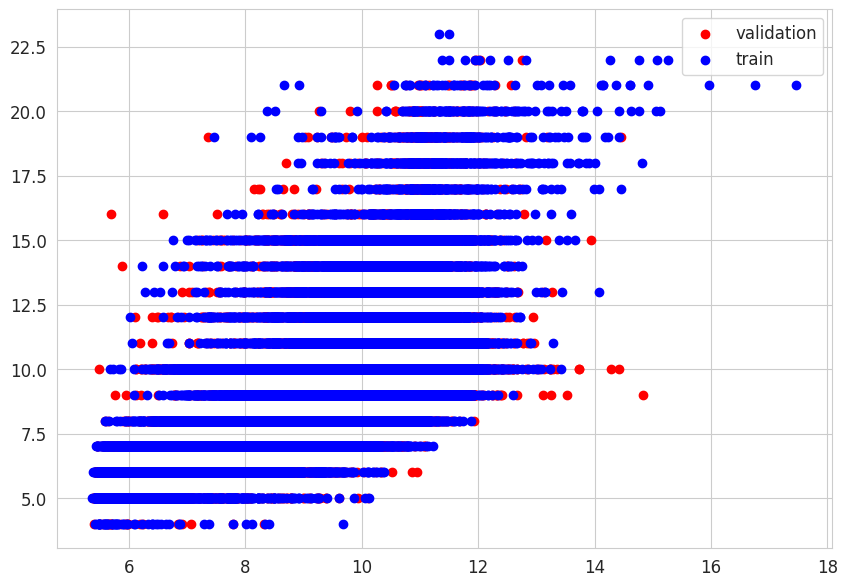

In [9]:
def plot_predictions(pred_val = y_pred_val, val_label = y_val, 
                     pred_train = y_pred_train, train_label = y_train):
    
    plt.scatter(pred_val, y_val, c='r', label="validation")
    plt.scatter(pred_train, train_label, c='b', label='train')
    
    plt.legend()
    plt.show()
    

plot_predictions()

In [11]:
# 1. load sample and test
submission = pd.read_csv(URL_SAMPLE)
test = pd.read_csv(URL_TEST, index_col='id')

# 2. predict and assign
submission['Rings'] = model.predict(test)

# 3. save to csv
submission.to_csv('#2[gamma]__xgboost__.csv', index=False)